In [151]:
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from community import community_louvain

## Getting Genre/Partition dictionaries

In [6]:
## Dictionary with Movie as Key and Genre as Value
# code taken from Group Project MWRP.ipynb because the import of this dictionary takes a long time

data_for_clusters =  pd.read_csv("10%Dataset.csv") 
data_for_clusters = data_for_clusters[["Movie", "MovieGenre"]]
dataclusters = data_for_clusters.drop_duplicates().reset_index(drop=True)

keys = dataclusters["Movie"]
values = dataclusters["MovieGenre"]

dict_mvs_genre = dict(zip(keys, values))
print(dict_mvs_genre)

{'B000NDFLWG': 'Documentary', 'B008FPU7AA': 'Horror', '1562229567': 'Documentary', '1888617047': 'Musicals', '6305508569': 'Action', '6304474415': 'Documentary', 'B0006FFRD4': 'Anime & Manga', 'B003BUAP10': 'Documentary', 'B000BB1NFO': 'Documentary', 'B00020HBN2': 'Anime & Manga', 'B000GAKJXM': 'Documentary', 'B00020HBNW': 'Anime & Manga', 'B00020HBNC': 'Anime & Manga', 'B0012EM5GK': 'Anime & Manga', 'B0002V7TJM': 'Documentary', 'B0002V7TJC': 'Documentary', 'B00004R7CH': 'Musicals', 'B0002V7TJW': 'Documentary', 'B00000IC80': 'Musicals', '6300246299': 'Horror', 'B00000IC8F': 'Musicals', 'B0014567LQ': 'Horror', 'B001DWNUBU': 'Documentary', 'B008R52L4I': 'Horror', 'B000H5U5IU': 'Horror', 'B000VZC4XA': 'Horror', 'B0071BY2YQ': 'Documentary', '0764004492': 'Horror', 'B006HNRSFE': 'Documentary', 'B0007M21Y4': 'Musicals', '6300266850': 'Horror', 'B000KGGJ04': 'Action', 'B000A9QK8M': 'Action', 'B003ZZ7TT2': 'Musicals', 'B000FP2PE4': 'Documentary', '6304462689': 'Documentary', 'B004J0DQS0': 'Doc

In [4]:
# Amount of different movies
print(len(dict_mvs_genre))

21788


## Preparing Graphs for Final Analysis and Experiment

In [9]:
# Importing the weighted network to keep as complete graph for final results
CG = nx.read_weighted_edgelist('10%Network.csv')

In [8]:
# Importing the weighted network to modify for experiment
G = nx.read_weighted_edgelist('10%Network.csv')

### Preparing Graph for Experiment
Removing weight-1 edges and subsequently occuring zero-degree nodes.

#### Removing Weight-1 Edges

In [10]:
# List of all links of the network, including their weight 
all_edges = list(G.edges.data())
all_edges[0]

('B000NDFLWG', '6305804427', {'weight': 1.0})

In [11]:
# List of all links with only 1 as weight
one_weight = [tpl for tpl in all_edges if tpl[2]["weight"] == 1.0]

In [12]:
# Comparing the total amount of edges and number of edges with weight 1
# Over half of the edges have only weight 1 (only one person liked both movies together)
print("Total amount of edges:", len(all_edges))
print("Amount of edges with weight 1:", len(one_weight))

Total amount of edges: 4174006
Amount of edges with weight 1: 2756884


In [13]:
# We remove from the network all edges with weight one
G.remove_edges_from(one_weight)

#### Removing Zero-Degree Nodes

In [14]:
# Get the weighted degrees of all nodes
all_degrees = list(G.degree(weight="weight"))
all_degrees[:5]

[('B000NDFLWG', 20.0),
 ('6305804427', 0),
 ('B0001IXT36', 339.0),
 ('B000EOTEIQ', 0),
 ('B000ARFPV2', 0)]

In [15]:
# Sort films by ascending degree (with weights)
all_degrees.sort(key=lambda x: x[1])
all_degrees[:5]

[('6305804427', 0),
 ('B000EOTEIQ', 0),
 ('B000ARFPV2', 0),
 ('B00003ETLD', 0),
 ('B000NJM6EG', 0)]

In [16]:
# Get all different number of occurences
# We see that there are most movies with degree 0
counts_occ = collections.Counter([x[1] for x in all_degrees])
counts_occ.most_common(10)

[(0, 7435),
 (2.0, 1037),
 (4.0, 733),
 (6.0, 444),
 (8.0, 305),
 (3.0, 287),
 (18.0, 251),
 (10.0, 204),
 (12.0, 203),
 (16.0, 186)]

In [17]:
# All the nodes that have degree 0
zero_degrees = [tpl[0] for tpl in all_degrees if tpl[1]==0]
len(zero_degrees)

7435

In [18]:
# We remove all the degree zero nodes as they will bias our clustering method (disconnected nodes)
G.remove_nodes_from(zero_degrees)

In [39]:
# New list of degrees containing only nodes with at least degree 2
degrees_weight = list(G.degree(weight="weight")) # weighted
degrees = list(G.degree()) # non weighted 

In [20]:
# Sorting in ascending order the movies by degree
# Now, lowest degree is two
degrees.sort(key=lambda x: x[1])
degrees[:5]

[('B0001I555G', 2.0),
 ('B0001I5556', 2.0),
 ('B002IVDL8W', 2.0),
 ('B000JGEXFS', 2.0),
 ('B000E8N8MK', 2.0)]

#### Some Characteristics of Reduced (Experiment) Network

In [21]:
# Different characteristics of current network
print("Number of nodes: ", len(G.nodes))
print("Number of edges: ", len(G.edges))
print("Density of the Graph: ", nx.density(G))

Number of nodes:  11995
Number of edges:  1417122
Density of the Graph:  0.019700304508235778


In [40]:
print("Reduced Network Average degree: ", sum([d for n, d in degrees])/float(len(G))) # way lower when not weight in
print("Complete Network Average degree: ", sum([d for n, d in CG.degree()])/float(len(CG)))

Reduced Network Average degree:  236.28545227177992
Complete Network Average degree:  429.64549665465773


In [74]:
print("Local clustering coefficient: ", nx.average_clustering(G))

Local clustering coefficient:  0.6493519345225568


In [75]:
print("Global clustering coefficient: ", nx.transitivity(G))

Global clustering coefficient:  0.44605369976061576


## Comparing Degree Distributions of Complete and Reduced Networks

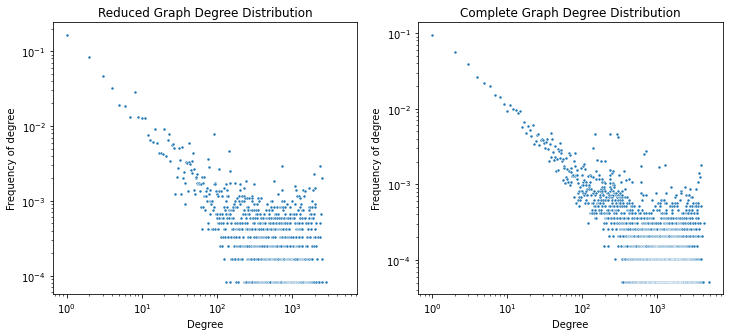

In [32]:
# Demonstrating the scale-free property of the reduced network
#f, ax = plt.subplots(figsize=(5, 5))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True)

for i in [0,1]:
    ax[i].set(xscale="log", yscale="log")
    ax[i].set_xlabel("Degree")
    ax[i].set_ylabel("Frequency of degree")

degree_freq_red = np.array(nx.degree_histogram(G))
degrees_red = range(len(degree_freq_red))
sns.scatterplot(x=degrees_red, y=degree_freq_red/degree_freq_red.sum(), marker=".", ax=ax[0])
ax[0].set_title("Reduced Graph Degree Distribution")

degree_freq_CG = np.array(nx.degree_histogram(CG))
degrees_CG = range(len(degree_freqCG))
sns.scatterplot(x=degrees_CG, y=degree_freq_CG/ degree_freq_CG.sum(), marker=".", ax=ax[1])
ax[1].set_title("Complete Graph Degree Distribution")

plt.show()

### Partitions of Reduced and Complete Graphs

In [34]:
# Use louvain algorithm to find partitions
# running this takes ~3 mins
division = community_louvain.best_partition(G, random_state=42)
print("We have " + str(len(set(division.values()))) + " divisions")

We have 1109 divisions


In [35]:
# Louvain on original graph
division_alt = community_louvain.best_partition(CG, random_state=42)
print("The original graph has " + str(len(set(division_alt.values()))) + " divisions")

The original graph has 876 divisions


In [41]:
# Checking if the graphs are connected
print("Reduced Graph connected?", nx.is_connected(G))
print("Complete Graph connected?", nx.is_connected(CG))

Reduced Graph connected? False
Complete Graph connected? False


In [43]:
print("Reduced Graph Number of Isolates:", nx.number_of_isolates(G))
print("Complete Graph Number of Isolates:", nx.number_of_isolates(CG))

Reduced Graph Number of Isolates: 0
Complete Graph Number of Isolates: 0


## Investigating Cluster Genre Majorities with Complete Network

In [67]:
# Getting the amount of nodes within each cluster
# All different clusters
different_clst_c = set(division_alt.values())
len(different_clst_c)

876

In [68]:
# A dictionary with the cluster as keys and the amount of movies as values
all_clusters_c = dict(collections.Counter(division_alt.values()))
sorted_clust_c = dict(sorted(all_clusters_c.items(), key=lambda x: x[1], reverse=True))

In [93]:
# All the number of movies within the different clusters
freqs_c = sorted(set(sorted_clust_c.values()))
print(freqs_c)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 20, 21, 23, 45, 149, 271, 457, 548, 981, 1169, 1173, 3471, 3588, 5278]


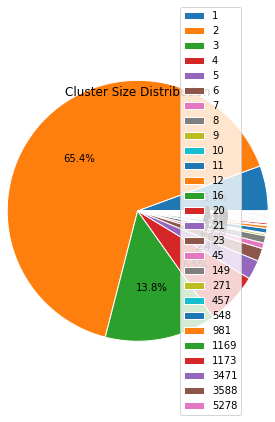

In [187]:
# Looking at the distribution of cluster sizes
# Count how many cluster have only one movie in, two, three...
count = Counter(sorted_clust_c.values())
count = sorted(count.items())
x = [i[0] for i in count]
y = [i[1] for i in count]
xx = np.arange(len(x))
plt.pie(y, autopct='%1.1f%%',radius=1.5, center=(4, 4),
           wedgeprops={"linewidth": 1, "edgecolor": "white"})
plt.legend(labels=x, loc="center right")
plt.title('Cluster Size Distribution')
plt.show()

In [95]:
# Dictionary of clusters as keys and lists of movies in those clusters as values
cc = {cl: [mv for mv in division_alt.keys() if division_alt[mv]==cl] for cl in different_clst_c}
cc = dict(sorted(cc.items()))
print(cc)

{0: ['B0009ML224', 'B003AILWWE'], 1: ['B00009PBHJ', 'B00009PBJ5', 'B00004NKCT', 'B00007JMD8', 'B00008DDV4', 'B00008DDV3', '5553637791', 'B000RPOCMA', 'B001NG9GZ0', 'B002XC3GMW', 'B00004CJRL', '6305280746', '6304342594', 'B000EHSVNW', '6300247031', 'B000083EDB', '6303514723', 'B000TJ6PBK', 'B00005JMDZ', 'B00005UQD5', 'B000083ED1', 'B0000509C0', 'B00005K3NT', 'B000EYK4KS', 'B00000FZ5B', 'B00005KHJR', 'B00005KHJM', '6305871078', 'B00026PA70', 'B000063K1F', 'B00004WI6N', '6305325812', 'B007VHCKJO', '6305872783', 'B00006IUK2', 'B0000D0YWP', 'B002E2QH7W', 'B0007WQHI0', 'B004P7CMSC', 'B000059PPN', 'B000059PPM', 'B00009MEFR', 'B00000JSJB', '6304147074', '6301536827', 'B0000BZNJP', 'B00000FDXH', 'B0009X75J2', '0790736055', 'B000083EH3', '6304270321', 'B00005U16K', 'B0000V6ST6', 'B00005R0EM', '6300182878', 'B00004RJCO', 'B00004Y3WA', '6302259428', '6305186677', '6305840032', 'B00000JLWQ', 'B00004CYAO', '1564427307', 'B0000AOWNJ', 'B0001GH7JA', '6305972052', 'B00004CZO5', '6302413591', 'B00004W3H

## Ratio of partitions corresponding to each genre

In [53]:
# Making sets of all films in each genre
#'Action', 'Horror', 'Documentary', 'Musicals', 'Anime & Manga'
Doc = {key for key in dict_mvs_genre if dict_mvs_genre[key] == 'Documentary'}
Act = {key for key in dict_mvs_genre if dict_mvs_genre[key] == 'Action'}
Hor = {key for key in dict_mvs_genre if dict_mvs_genre[key] == 'Horror'}
Mus = {key for key in dict_mvs_genre if dict_mvs_genre[key] == 'Musicals'}
AnM = {key for key in dict_mvs_genre if dict_mvs_genre[key] == 'Anime & Manga'}

In [54]:
def lookup(genre):
    """Function taking as input a genre and returning the movie set corresponding to that genre"""
    if genre=='Documentary':
        return Doc
    if genre=='Action':
        return Act
    if genre=='Musicals':
        return Mus
    if genre=='Anime & Manga':
        return AnM
    if genre=='Horror':
        return Hor  

In [55]:
def pct_genre(lst_movies, genre):
    """Takes a genre and a list of movies and returns what percentage of movies have this genre"""
    if len(lst_movies)==0:
        return 0
    else:
        per = round(len([mv for mv in lst_movies if mv in genre])/len(lst_movies)*100, 2)
        return per

In [56]:
def pct_cl_genre(clkey, cldict, genre):
    """Takes as input a cluster key, a cluster dictionary and a genre and outputs the percentage of genre within a 
    specific cluster of the dictionary"""
    mvies = cldict[clkey] 
    p = pct_genre(mvies, lookup(genre))
    return p

In [72]:
# Let us try out the last function
pct_cl_genre(4, cc, "Documentary")

34.22

## Results for the percentages in dataframe

In [96]:
# Create an empty dataframe with as columns the different genres and as index the 12 different clusters
sorted_complete = dict(sorted(cc.items()))
cl_df_complete = pd.DataFrame(columns=sorted(list(set(values))), index=list(sorted_complete.keys()))

In [97]:
# Adding the percentage values to the dataframe row by row
for i in list(cl_df_complete.index):
    pct = pd.Series({k:pct_cl_genre(i, cc, k) for k in list(cl_df_complete.columns)})
    cl_df_complete.loc[i] = pct
cl_df_complete

,Action,Anime & Manga,Documentary,Horror,Musicals
0,0.0,0.0,100.0,0.0,0.0
1,5.32,3.15,15.36,72.1,4.07
2,0.68,3.92,81.42,4.01,9.97
3,7.14,3.13,59.64,7.18,22.91
4,11.63,10.95,34.22,26.43,16.77
...,...,...,...,...,...
871,0.0,0.0,100.0,0.0,0.0
872,0.0,0.0,100.0,0.0,0.0
873,0.0,0.0,100.0,0.0,0.0
874,0.0,0.0,100.0,0.0,0.0


In [98]:
# Changing the orientation of the table to manipulate it more easily
new_complete = cl_df_complete.T
new_complete

,0,1,2,3,4,5,6,7,8,9,...,866,867,868,869,870,871,872,873,874,875
Action,0.0,5.32,0.68,7.14,11.63,0.0,0.0,0.0,0.0,19.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anime & Manga,0.0,3.15,3.92,3.13,10.95,0.0,0.0,0.0,0.0,28.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Documentary,100.0,15.36,81.42,59.64,34.22,100.0,0.0,100.0,100.0,32.41,...,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
Horror,0.0,72.1,4.01,7.18,26.43,0.0,100.0,0.0,0.0,8.35,...,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Musicals,0.0,4.07,9.97,22.91,16.77,0.0,0.0,0.0,0.0,11.61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# Creating a list where there is no genre majority
# also how much of each majority
c= 0
lst_less_complete = [] # genre minority
lst_more_complete = [] # genre majority
for x in list(new_complete.columns):
    if any([y > 50 for y in list(new_complete[x])]):
        c+= 1
        lst_more_complete.append(x)
    else:
        lst_less_complete.append(x)

### Final Project Results - Percentage of Movie Clusters with Genre Majority

In [135]:
print(f"Percentage of clusters where genre majority exists: {c/len(different_clst_c)*100}%")

Percentage of clusters where genre majority exists: 96.46118721461188%


In [101]:
print("Number of clusters out of 12 where there is a genre majority:", c)
print("Clusters where there is no genre majority:", lst_less_complete)
#print("Clusters with majority:", lst_more_complete)

Number of clusters out of 12 where there is a genre majority: 845
Clusters where there is no genre majority: [4, 9, 10, 11, 24, 26, 40, 42, 67, 88, 138, 140, 218, 267, 313, 328, 342, 354, 423, 438, 483, 487, 529, 556, 597, 656, 743, 759, 763, 820, 826]


### Additional (PieChart) Visualisation

In [78]:
keys_name = {name: i for i, name in enumerate(cc.keys())}
def get_index(nm):
    return keys_name[nm]

In [165]:
def make_pie(clster, df):
    name = get_index(clster)
    x = list(df.iloc[name])
    y = list(df.columns)
    colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(x)))
    fig, ax = plt.subplots()
    ax.pie(x, autopct='%1.1f%%', colors=colors, radius=3, center=(4, 4),
           wedgeprops={"linewidth": 1, "edgecolor": "white"})
    ax.legend(labels=y, loc="lower right")
    ax.set_title(f"Cluster {clster}: % per Genre")
    ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
           ylim=(0, 8), yticks=np.arange(1, 8))
    plt.axis('off')
    plt.show()

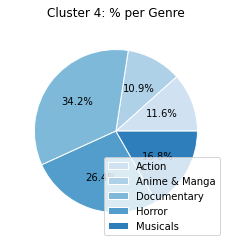

In [166]:
make_pie(4, cl_df_complete)

#### Pie Charts for Clusters without Genre Majority

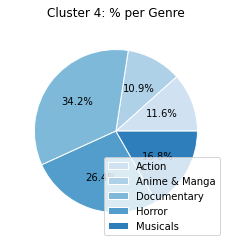

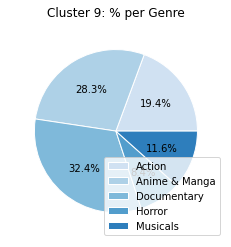

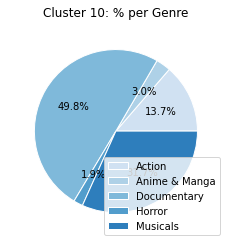

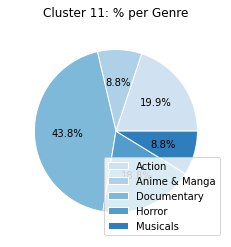

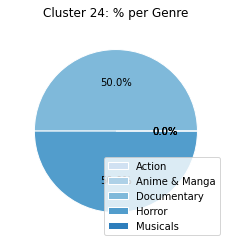

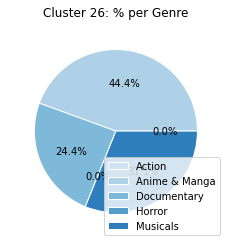

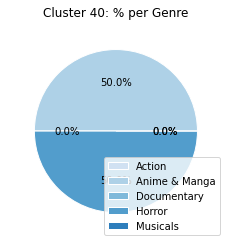

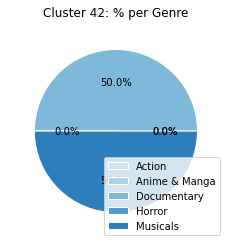

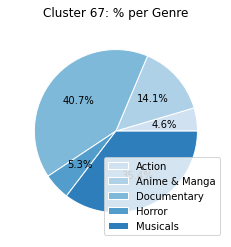

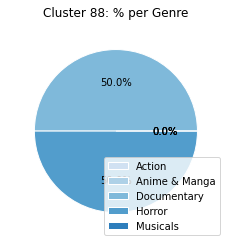

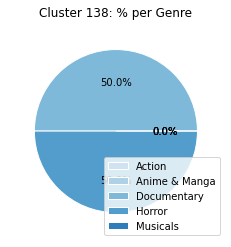

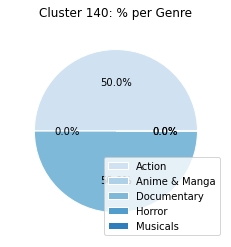

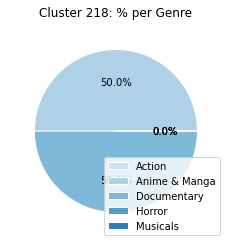

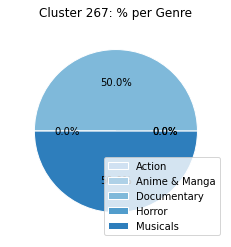

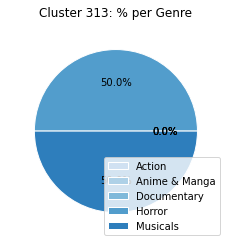

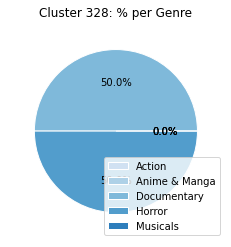

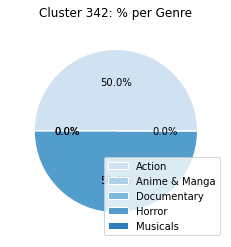

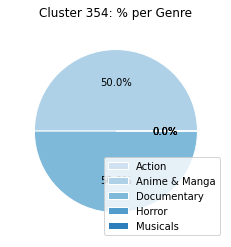

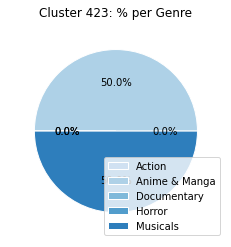

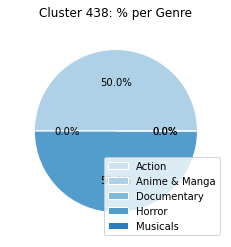

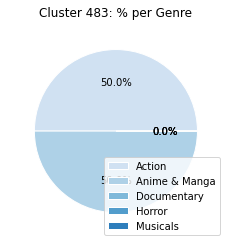

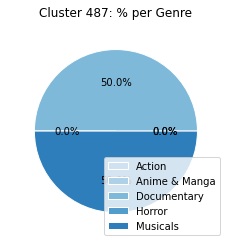

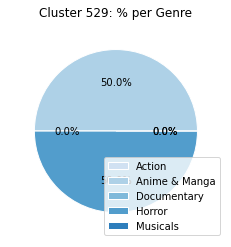

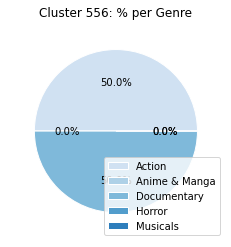

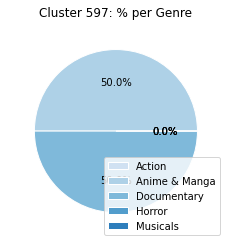

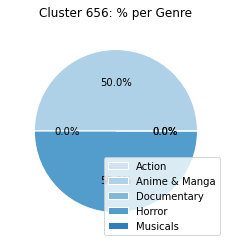

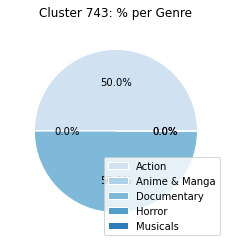

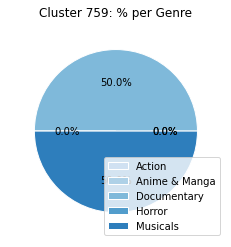

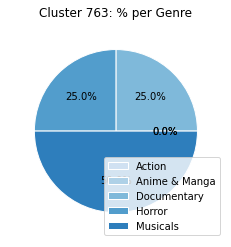

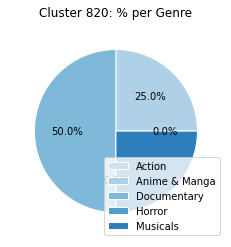

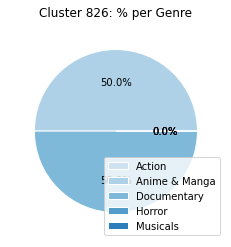

In [82]:
for x in lst_less_complete:
    make_pie(x, cl_df_complete)

## Additional Experiment for Genre Majority in Reduced Network

In [104]:
# Using the same steps as above
different_clst = set(division.values())

# A dictionary with the cluster as keys and the amount of movies as values
all_clusters = dict(collections.Counter(division.values()))
sorted_clust = dict(sorted(all_clusters.items(), key=lambda x: x[1], reverse=True))

# All the number of movies within the different clusters
freqs = sorted(set(sorted_clust.values()))

# Dictionary of clusters as keys and lists of movies in those clusters as values
clts = {cl: [mv for mv in division.keys() if division[mv]==cl] for cl in different_clst}
clts = dict(sorted(clts.items()))
print(clts)

{0: ['B00000JS65', 'B00000JS6O'], 1: ['B0001I555G', 'B0001I5556'], 2: ['B0007Y08JM', 'B00004TSYQ'], 3: ['B00005MKJ2', 'B001QZZFTO'], 4: ['B00009PBHJ', 'B00009PBJ5', 'B0002HDXTQ', '0767043367', 'B00007CVSP', 'B00004CI5P', 'B000060MYF', 'B001NKWLBW', 'B000E6ESSA', 'B003VZNAUS', 'B000089QAD', 'B00007CVRX', 'B00008977J', 'B004SUDQDG', '6304733941', 'B001EN46MK', 'B00008QS9K', 'B00008L3SI', 'B00005MP5W', 'B00004YNUH', 'B0044RFTCY', 'B00540G3G6', 'B004AR4WSA', 'B000068UY9', '6301996135', 'B002OQZE5E', 'B0002X8U4I', 'B000KX0IN6', 'B0007Q6VXC', 'B00061RZME', 'B000UXX5HC', 'B0002849HK', 'B0002849IY', 'B001QB5SDG', 'B00004WDDX', '6305077525', 'B00005PJ8S', '6304935838', 'B00005Q4GW', '6304960638', 'B00001YXDF', '6304935765', 'B000EHSVRS', '630305725X', 'B00004TJFI', 'B00005QFGC', 'B00158K0RY', '6303057225', 'B001BN1ZHW', 'B0013D8LOU', 'B0013D8LOK', 'B002DPH936', 'B0007UNSZW', 'B00004CQQW', '6302277426', 'B00005MEPB', 'B004GFGUCC', '6305962987', 'B00004U40S', '6305963126', 'B004GFGUCW', 'B002GWDK

In [106]:
# Create an empty dataframe with as columns the different genres and as index the 12 different clusters
cl_df = pd.DataFrame(columns=sorted(list(set(values))), index=list(clts.keys()))

# Adding the percentage values to the dataframe row by row
for i in list(cl_df.index):
    pct = pd.Series({k:pct_cl_genre(i, clts, k) for k in list(cl_df.columns)})
    cl_df.loc[i] = pct

# Changing the orientation of the table to manipulate it more easily
new = cl_df.T

In [107]:
# Creating a list  of instances where there is no genre majority
r = 0
lst_less = [] 
lst_more = []
for x in list(new.columns):
    if any([y > 50 for y in list(new[x])]):
        r += 1
        lst_more.append(x)
    else:
        lst_less.append(x)

#### Final Result Experiment

In [112]:
print(f"Percentage of clusters where genre majority exists: {round(r/len(different_clst)*100, 2)}%")

Percentage of clusters where genre majority exists: 98.11%


In [113]:
print("Number of clusters out of 12 where there is a genre majority:", r)
print("Clusters where there is no genre majority:", lst_less)

Number of clusters out of 12 where there is a genre majority: 1088
Clusters where there is no genre majority: [4, 8, 9, 11, 16, 38, 49, 124, 221, 243, 410, 496, 508, 634, 680, 753, 907, 951, 957, 975, 996]


### Final Extra Experiment Looking at Genre Majority only Within Large Clusters (Using Complete Network)

In [161]:
# We define some large clusters in order to be able to analyse them more closely
# Calculating percentages for clusters that don't have many films doesn't make much sense
# Choosing to take clusers from 10 movies on
large_clusters = [k for k in sorted_clust_c.keys() if sorted_clust_c[k] > 10]
print("Number of clusters with over 50 movies:", len(large_clusters))
print("Labels of those large clusters:", large_clusters)

# Dictionary of movie and cluster to which it belongs, only keeping the ones in large clusters
dict_clst = {k:division_alt[k] for k in division_alt.keys() if division_alt[k] in large_clusters}
# Dictionary of clusters as keys and lists of movies in those clusters as values
lc = {cl: [mv for mv in division_alt.keys() if division_alt[mv]==cl] for cl in large_clusters}

Number of clusters with over 50 movies: 24
Labels of those large clusters: [3, 1, 9, 2, 4, 67, 11, 23, 10, 14, 26, 49, 27, 18, 96, 32, 29, 31, 61, 46, 53, 71, 122, 262]


In [162]:
# Create an empty dataframe with as columns the different genres and as index the 12 different clusters
df = pd.DataFrame(columns=sorted(list(set(values))), index=list(lc.keys()))
# Adding the percentage values to the dataframe row by row
for i in list(df.index):
    pct = pd.Series({k:pct_cl_genre(i, lc, k) for k in list(df.columns)})
    df.loc[i] = pct
# Changing the orientation of the table to manipulate it more easily
largecl = df.T
# Creating a list  of instances where there is no genre majority
i = 0
lst_no = []
lst_yes = []
for x in list(largecl.columns):
    if any([y > 50 for y in list(largecl[x])]):
        i += 1
print(f"Percentage of clusters where genre majority exists: {i/len(different_clst_c)*100}%")

Percentage of clusters where genre majority exists: 2.054794520547945%


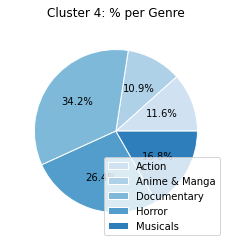

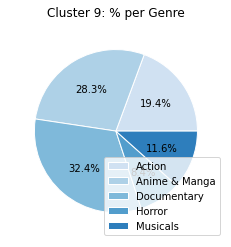

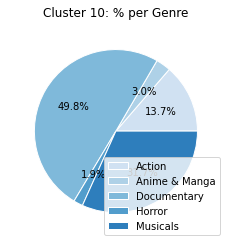

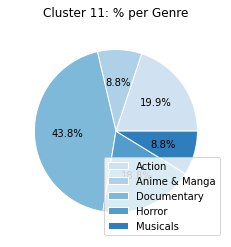

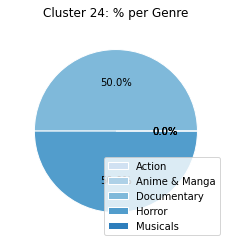

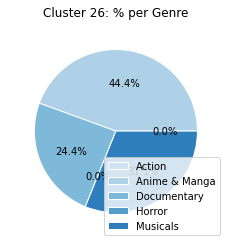

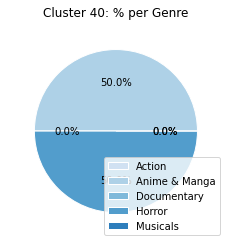

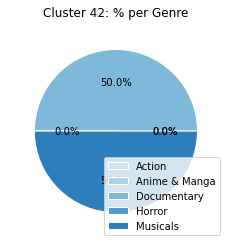

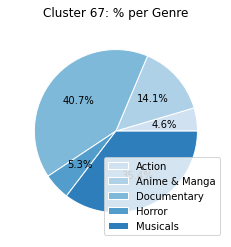

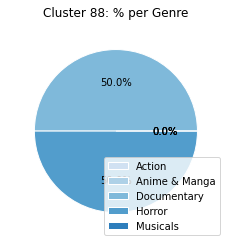

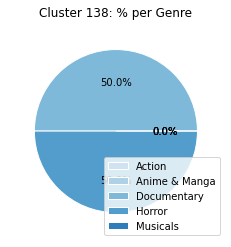

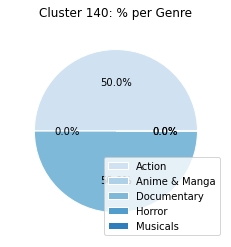

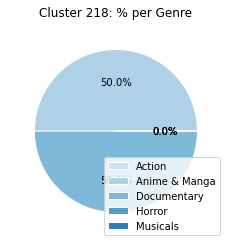

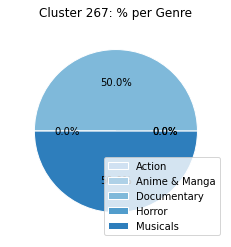

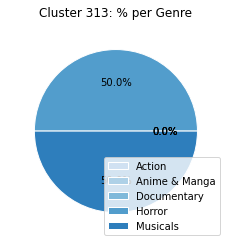

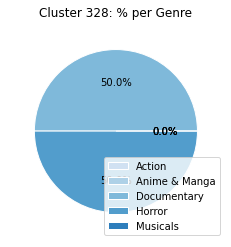

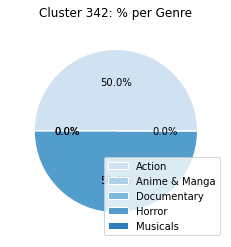

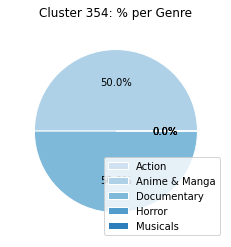

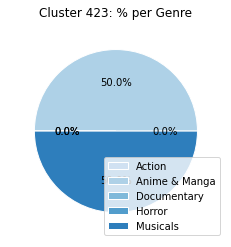

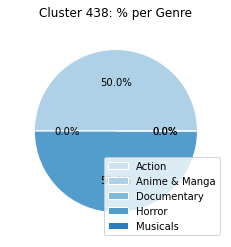

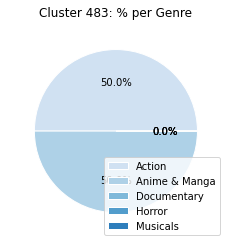

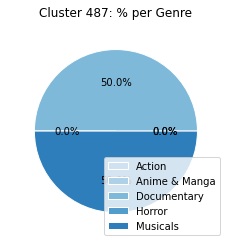

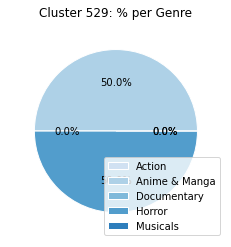

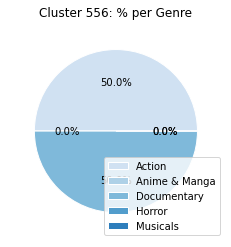

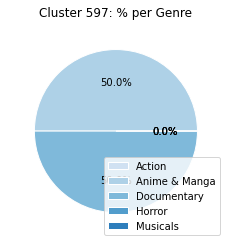

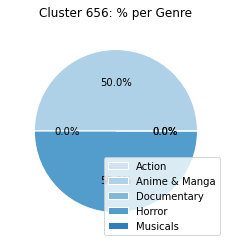

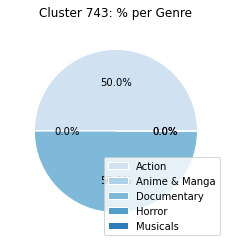

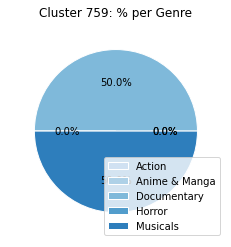

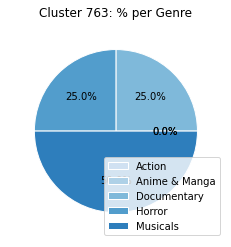

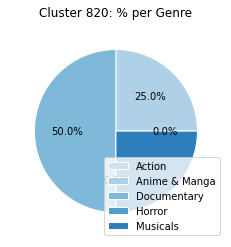

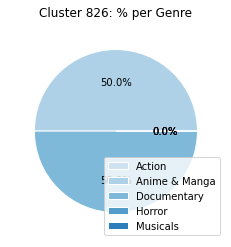

In [167]:
for x in lst_no:
    make_pie(x, cl_df_complete)

## Section for Additional Experimentation 

#### Looking at Average Size of Cluster Containing Highest and Lowest (Weighted) Node Degree

In [190]:
degrees_complete_weighted = list(CG.degree(weight="weight"))
degrees_complete_weighted.sort(key=lambda x: x[1], reverse=True)
highest_10 = degrees_complete_weighted[:10]

In [191]:
degrees_complete_weighted.sort(key=lambda x: x[1])
lowest_10 = degrees_complete_weighted[:10]

In [192]:
clst_highest = [division_alt[x[0]] for x in highest_10]
clst_lowest = [division_alt[x[0]] for x in lowest_10]
size_high = [sorted_clust_c[x] for x in clst_highest]
size_low = [sorted_clust_c[x] for x in clst_lowest]
avg_high = sum(size_high)/len(size_high)
avg_low = sum(size_low)/len(size_low)
print(avg_high)
print(avg_low)

457.0
4940.0


#### Run several rounds to see average amount of clusters found by Louvain

In [ ]:
lst_len = []
lst_div = []
for i in range(0, 5):
    d = community_louvain.best_partition(CG)
    lst_len.append(len(set(d.values())))
    lst_div.append(d)
    
print(f"Average amount of clusters:{sum(lst_len)/len(lst_len)}")

#### Look into degree of clusters with two movies
Interesting, since it shows that two small clusters do also not comprise strongly co-liked movies.

In [197]:
two_movies = [k for k in sorted_clust_c.keys() if sorted_clust_c[k]==2]
print(f"{len(two_movies)}/{len(different_clst_c)} contain two movies")
# Get average weighted degree of all clusters with two movies 
mv_two = [k for k in division_alt.keys() if division_alt[k] in two_movies]
degrees_w_two = [x for x in degrees_complete_weighted if x[0] in mv_two]
averge_degree = sum([x[1] for x in degrees_w_two])/len(degrees_w_two)

deg_w = list(CG.degree())
dgw2 = [x for x in deg_w if x[0] in mv_two]
avdg = sum([x[1] for x in dgw2])/len(dgw2)
print("Weighted average degree of nodes within clusters of size 2:", averge_degree)
print("Non-weighted average degree of nodes within clusters of size 2:", avdg)

573/876 contain two movies
Weighted average degree of nodes within clusters of size 2: 2.054101221640489
Non-weighted average degree of nodes within clusters of size 2: 1.0462478184991273
